In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork



device: cuda


2023-12-04 01:50:33.564664: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 01:50:34.347642: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 01:50:34.857648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 01:50:34.857679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 01:50:34.875833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    """
    Reconstruct a 3D volume using a binary mask and flattened data volume.

    Parameters:
    - vol_shape: tuple of int, shape of the original 3D volume.
    - binary_mask: 1D array-like, flattened binary mask indicating the active voxels in the original volume.
    - data_vol: 1D array-like, flattened data values corresponding to the active voxels.
    - order: {'C', 'F'}, optional, default is 'C'. Specify the memory layout of the reconstructed volume.
             'C' means C-style (row-major), 'F' means Fortran-style (column-major).

    Returns:
    - 3D numpy array, the reconstructed volume.
    """
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    # Convert the binary mask to an index mask
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return view_vol.reshape(vol_shape, order=order)

## Load data

In [3]:
subj = 1
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


trial tensor([[2615]])
idx 0
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])


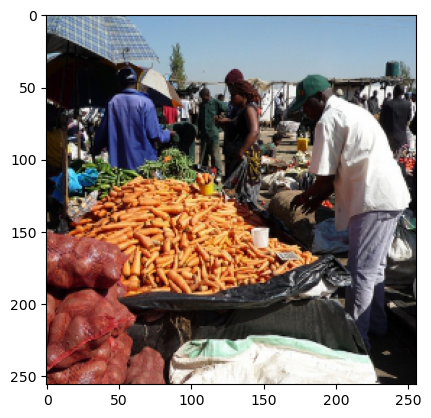

annotation ['People shopping in an open market for vegetables.', 'An open market full of people and piles of vegetables.', 'People are shopping at an open air produce market.', 'Large piles of carrots and potatoes at a crowded outdoor market.', 'People shop for vegetables like carrots and potatoes at an open air market.']
things ['accessory', 'food', 'person']


In [4]:
import nibabel as nib
data_path = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz'%subj).get_fdata()==1
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
anat_img = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/T1_to_func1pt8mm.nii.gz'

annotation = np.load(data_path + '/subj%02d_annot.npy'%subj,allow_pickle=True)
things = np.load(data_path + '/subj%02d_things.npy'%subj,allow_pickle=True)
num_train = 8559 + 300
num_val = 982
batch_size = val_batch_size = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco","trial")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco,trial) in enumerate(val_dl):
    print("trial",trial)
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    plt.imshow(img_input[0].permute(1,2,0))
    plt.show()
    print("annotation",annotation[trial[0]])
    print("things",things[trial[0]])
    break



## Load models

In [5]:
model_name="prior_257_final_subj01_bimixco_softclip_byol"
autoencoder_name="autoencoder_subj01_4x_locont_no_reconst"
img_variations = False

out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100 #100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    )

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
)

outdir = f'/scratch/cl6707/Projects/neuro_interp/fMRI-reconstruction-NSD/train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

ViT-L/14 cuda
ckpt_path /scratch/cl6707/Projects/neuro_interp/fMRI-reconstruction-NSD/train_logs/prior_257_final_subj01_bimixco_softclip_byol/last.pth
EPOCH:  239


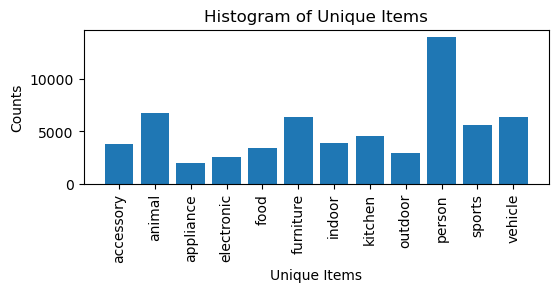

In [6]:
things_all = []
for thing in things:
    things_all.extend(thing)
things_all = np.unique(things_all,return_counts=True)#,return_counts=True)
unique_items, item_counts = things_all
plt.figure(figsize=(6, 2))
plt.bar(unique_items, item_counts)
plt.xticks(rotation=90)
plt.xlabel('Unique Items')
plt.ylabel('Counts')
plt.title('Histogram of Unique Items')
plt.show()

## Inspect models with Captum

### Highlevel (Sementic) Attribution

In [7]:
def clip_voxels_target(voxel,img):
    clip_target = clip_extractor.embed_image(img).float()
    clip_voxels, clip_voxels_proj = diffusion_prior.voxel2clip(voxel)
    clip_voxels_norm = nn.functional.normalize(clip_voxels_proj.flatten(1), dim=-1)
    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
    num_epochs = 240
    epoch=239
    mixup_pct = .33
    soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]

    loss_nce = utils.soft_clip_loss(
        clip_voxels_norm,
        clip_target_norm,
        temp=epoch_temp)

    return loss_nce.unsqueeze(0)

def plot_img_attribution(img,img_attr,caption=None):
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(img)
    axes[0].set_title("Original Image"+caption)
    axes[0].axis('off')
    axes[1].imshow(img_attr)
    axes[1].set_title("Image Attribution"+caption)
    axes[1].axis('off')
    plt.show()


labels: ['accessory', 'food', 'person']
annotations:
People shopping in an open market for vegetables.
An open market full of people and piles of vegetables.
People are shopping at an open air produce market.
Large piles of carrots and potatoes at a crowded outdoor market.
People shop for vegetables like carrots and potatoes at an open air market.


/ext3/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


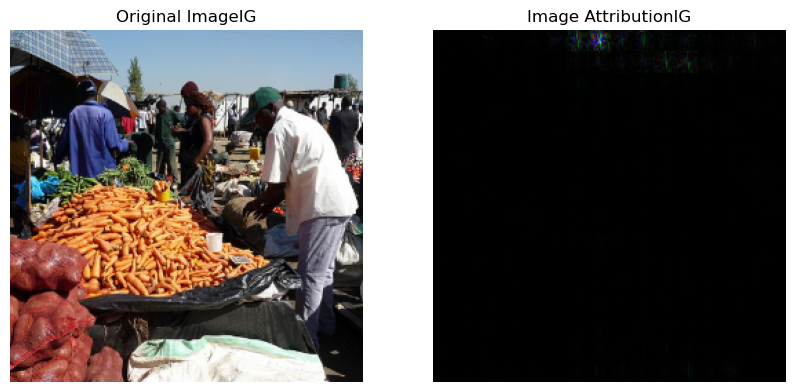

IG attribution
IG image attribution:615.7149
IG voxel attribution:0.1287


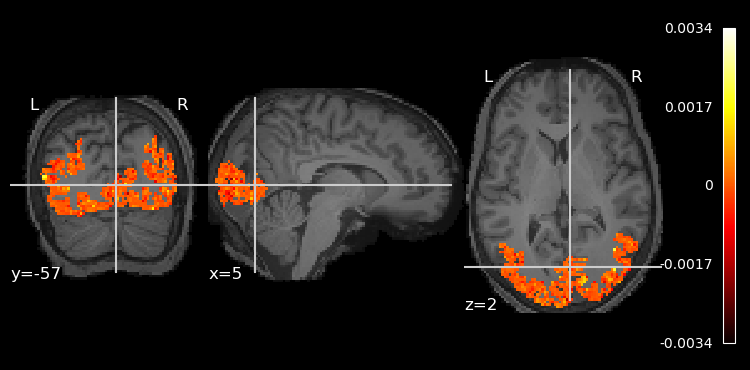

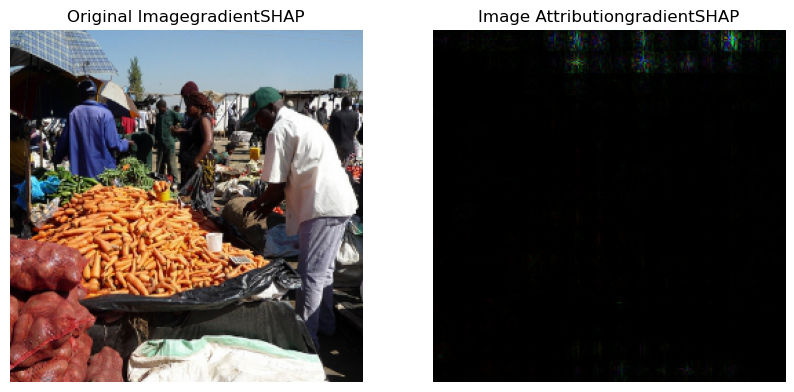

SHAP attribution
gradientSHAP image attribution:1318.4374
gradientSHAP voxel attribution:-0.1085
labels: ['appliance', 'food', 'kitchen', 'person']
annotations:
a couple of people are cooking in a room
Two people in chef's outfits cooking inside a kitchen. 
two chefs working on seperate parts of a meal at a restaurant
a couple of chefs standing in front of some food 
A couple of cooks standing in a kitchen making food.


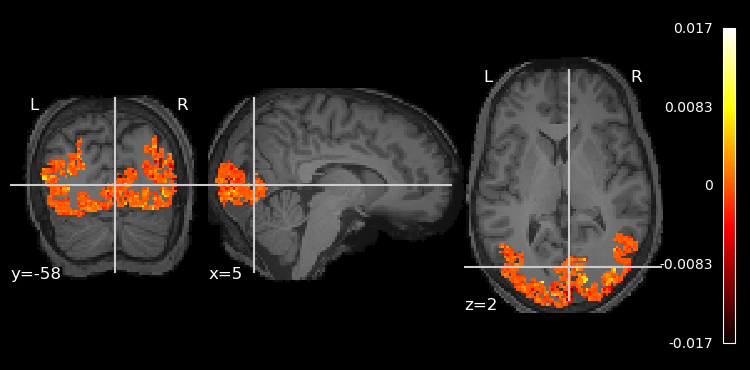

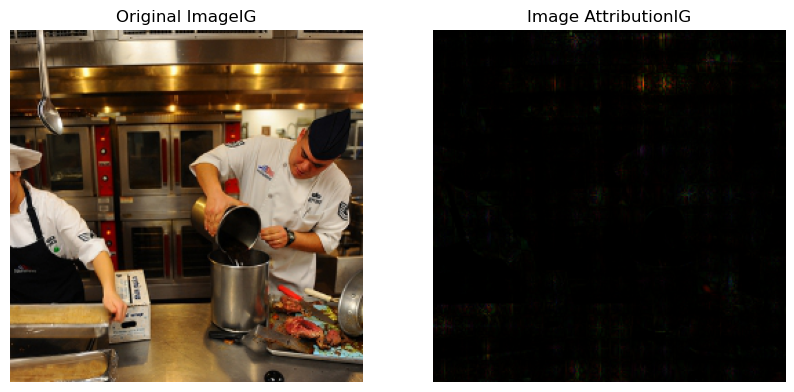

IG attribution
IG image attribution:1410.3101
IG voxel attribution:0.1245


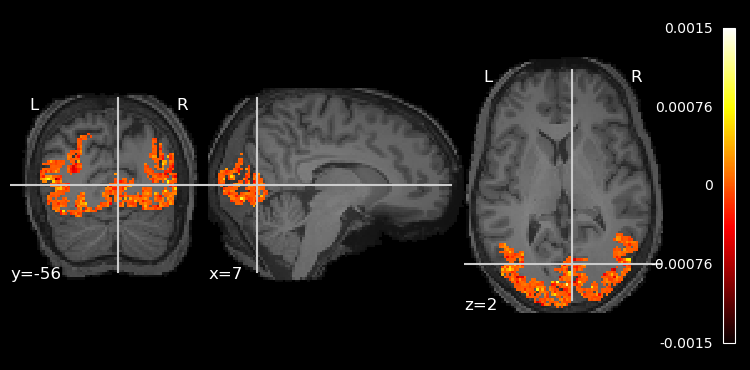

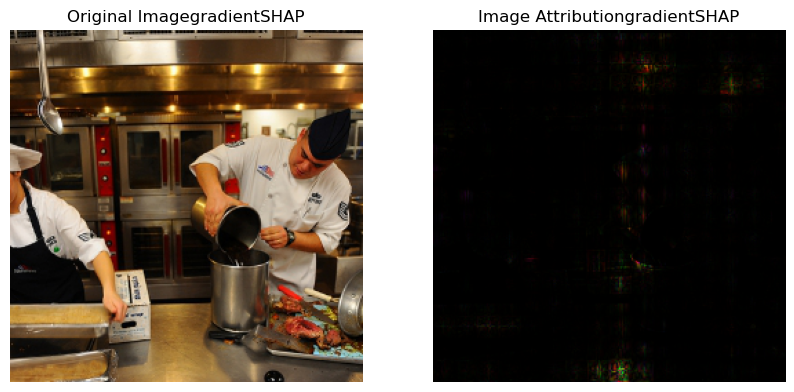

SHAP attribution
gradientSHAP image attribution:1239.3948
gradientSHAP voxel attribution:0.0416
labels: ['person', 'sports']
annotations:
A person in a wetsuit surfing on a turquoise wave.
A male surfer riding a wave on the ocean.
A young man with a surfboard at the ocean waters surfing
A surfer is riding the top of a wave.
a person standing on a surfboard riding a wave


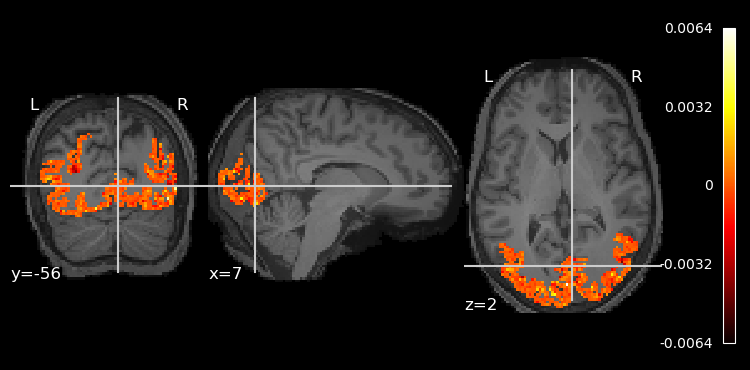

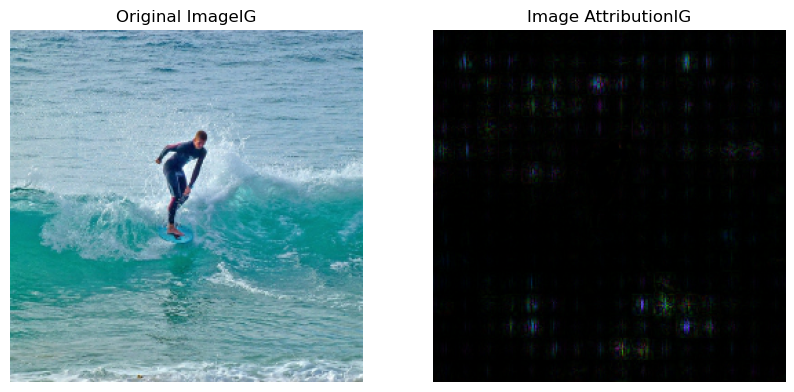

IG attribution
IG image attribution:2434.0547
IG voxel attribution:0.0912


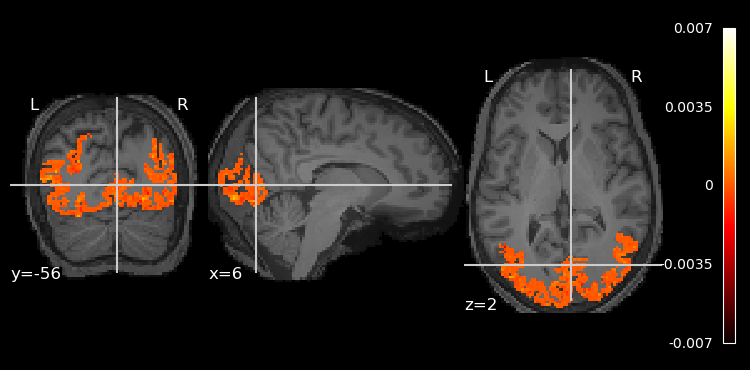

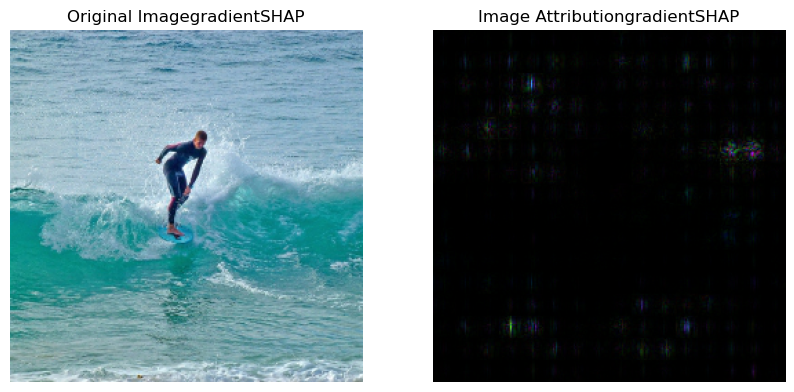

SHAP attribution
gradientSHAP image attribution:1896.0386
gradientSHAP voxel attribution:0.0002


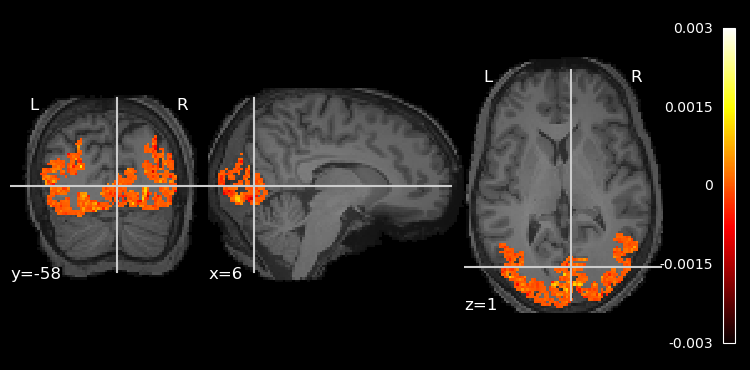

In [12]:
# import captum.attr.IntegratedGradients as IG
# 257 * 768
import captum
from tqdm.notebook import tqdm
import utils
from nilearn import plotting
from captum.attr import visualization as viz
output_dir = '/scratch/cl6707/Projects/neuro_interp/output/figures/'
save_fig = False
# Calculate attribution for the contrastive loss

IG_voxel_img_clip = captum.attr.IntegratedGradients( clip_voxels_target)
# gradientSHAP
gradientSHAP_img_clip = captum.attr.GradientShap(clip_voxels_target)

count = 0
for val_i, (voxel, img, coco,trial) in enumerate(val_dl):
    # if len(things[trial[0]])>1:
    #     continue
    if count == 3:
        break
    # print("annotation",annotation[trial[0]])
    print("labels:",things[trial[0]])
    print("annotations:")
    for annotation_i in annotation[trial[0]]:
        print(annotation_i)


    voxel = torch.mean(voxel,axis=1).to(device).float()
    img = img.to(device)

    IG_voxel_attr, IG_img_attr = IG_voxel_img_clip.attribute( inputs = (voxel,img), baselines = (torch.zeros_like(voxel),torch.zeros_like(img)))

    IG_img_attr = np.transpose(IG_img_attr.squeeze().cpu().detach().numpy(), (1, 2, 0))
    IG_img_attr = np.abs(IG_img_attr)
    IG_img_attr = (IG_img_attr - np.min(IG_img_attr))/ (np.max(IG_img_attr) - np.min(IG_img_attr))
    
    plot_img_attribution(img.squeeze().cpu().detach().numpy().transpose(1,2,0),IG_img_attr,caption="IG")

    IG_voxel_attr = IG_voxel_attr.cpu().detach().numpy()
    # IG_voxel_attr = np.abs(IG_voxel_attr)
    # IG_voxel_attr = (IG_voxel_attr - np.min(IG_voxel_attr))/ (np.max(IG_voxel_attr) - np.min(IG_voxel_attr))
    IG_reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), IG_voxel_attr)
    IG_reconstructed = np.nan_to_num(IG_reconstructed)

    IG_ni_img = nib.Nifti1Image(IG_reconstructed,affine=nsdgeneral_affine)
    print('IG attribution')
    plotting.plot_stat_map(IG_ni_img,
                        bg_img=anat_img,
                        cmap='hot',
                        output_file=os.path.join(output_dir,f'{model_name}_subj{subj}_trial{trial[0]}_voxel_attr.png') if save_fig else None,)

    print('IG image attribution:{:.4f}'.format(IG_img_attr.sum().item()))
    print('IG voxel attribution:{:.4f}'.format(IG_voxel_attr.sum().item()))

    gradientSHAP_voxel_attr, gradientSHAP_img_attr = gradientSHAP_img_clip.attribute( inputs = (voxel,img), baselines = (torch.zeros_like(voxel),torch.zeros_like(img)))

    gradientSHAP_img_attr = np.transpose(gradientSHAP_img_attr.squeeze().cpu().detach().numpy(), (1, 2, 0))
    gradientSHAP_img_attr = np.abs(gradientSHAP_img_attr)
    gradientSHAP_img_attr = (gradientSHAP_img_attr - np.min(gradientSHAP_img_attr))/ (np.max(gradientSHAP_img_attr) - np.min(gradientSHAP_img_attr))

    plot_img_attribution(img.squeeze().cpu().detach().numpy().transpose(1,2,0),gradientSHAP_img_attr,caption="gradientSHAP")

    gradientSHAP_voxel_attr = gradientSHAP_voxel_attr.cpu().detach().numpy()
    # gradientSHAP_voxel_attr = np.abs(gradientSHAP_voxel_attr)
    # gradientSHAP_voxel_attr = (gradientSHAP_voxel_attr - np.min(gradientSHAP_voxel_attr))/ (np.max(gradientSHAP_voxel_attr) - np.min(gradientSHAP_voxel_attr))
    gradientSHAP_reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), gradientSHAP_voxel_attr)
    gradientSHAP_reconstructed = np.nan_to_num(gradientSHAP_reconstructed)

    gradientSHAP_ni_img = nib.Nifti1Image(gradientSHAP_reconstructed,affine=nsdgeneral_affine)
    print('SHAP attribution')
    plotting.plot_stat_map(gradientSHAP_ni_img,
                        bg_img=anat_img,
                        cmap='hot',
                        output_file=os.path.join(output_dir,f'{model_name}_subj{subj}_trial{trial[0]}_voxel_attr.png') if save_fig else None,)
    print('gradientSHAP image attribution:{:.4f}'.format(gradientSHAP_img_attr.sum().item()))
    print('gradientSHAP voxel attribution:{:.4f}'.format(gradientSHAP_voxel_attr.sum().item()))

    count += 1  

### CLIP-fMRI ~ CLIP-Image MSE Loss

In [ ]:
import captum
from tqdm.notebook import tqdm
import utils
from nilearn import plotting
from captum.attr import visualization as viz
save_fig = False
def clip_fMRI_target(voxel,img):
    clip_target = clip_extractor.embed_image(img).float()
    clip_voxels, clip_voxels_proj = diffusion_prior.voxel2clip(voxel)
    loss_prior, aligned_clip_voxels = diffusion_prior(text_embed=clip_voxels, image_embed=clip_target)

    return loss_prior.unsqueeze(0)

IG_voxel_fMRI_clip = captum.attr.IntegratedGradients( clip_fMRI_target)

count = 0
with torch.no_grad():
    for val_i, (voxel, img, coco,trial) in enumerate(val_dl):
        if len(things[trial[0]])>1:
            continue
        if count == 2:
            break
        # print("annotation",annotation[trial[0]])
        print("things",things[trial[0]])
        for annotation_i in annotation[trial[0]]:
            print("annotation",annotation_i)


        voxel = torch.mean(voxel,axis=1).to(device).float()
        img = img.to(device)

        
        IG_voxel_attr, IG_img_attr = IG_voxel_fMRI_clip.attribute( inputs = (voxel,img), baselines = (torch.zeros_like(voxel),torch.zeros_like(img)))
        IG_voxel_attr = IG_voxel_attr.cpu().detach().numpy()
        IG_voxel_attr = np.abs(IG_voxel_attr)
        IG_voxel_attr = (IG_voxel_attr - np.min(IG_voxel_attr))/ (np.max(IG_voxel_attr) - np.min(IG_voxel_attr))
        reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), IG_voxel_attr)
        reconstructed = np.nan_to_num(reconstructed)


        ni_img = nib.Nifti1Image(reconstructed,affine=nsdgeneral_affine)
        plotting.plot_stat_map(ni_img,
                            bg_img=anat_img,
                            cmap='hot',
                            output_file=os.path.join(output_dir,f'{model_name}_subj{subj}_trial{trial[0]}_voxel_attr.png') if save_fig else None,)
        IG_img_attr = np.transpose(IG_img_attr.squeeze().cpu().detach().numpy(), (1, 2, 0))
        IG_img_attr = np.abs(IG_img_attr)
        IG_img_attr = (IG_img_attr - np.min(IG_img_attr))/ (np.max(IG_img_attr) - np.min(IG_img_attr))
        
        plot_img_attribution(img.squeeze().cpu().detach().numpy().transpose(1,2,0),IG_img_attr,caption="IG")
        
        print('image attribution:{:.4f}'.format(IG_img_attr.sum().item()))
        print('voxel attribution:{:.4f}'.format(IG_voxel_attr.sum().item()))
        count += 1  

### Low level Attribution

#### voxel2sd low level model loading

In [5]:
import kornia
from kornia.augmentation.container import AugmentationSequential
import torch.nn.functional as F
# # Configurations
model_name = "autoencoder"
modality = "image" # ("image", "text")
image_var = 'images' if modality=='image' else None  # trial
clamp_embs = False # clamp embeddings to (-1.5, 1.5)

voxel_dims = 1 # 1 for flattened 3 for 3d
n_samples_save = 4 # how many SD samples from train and val to save

use_reconst = False
batch_size = 8
num_epochs = 120
lr_scheduler = 'cycle'
initial_lr = 1e-3
max_lr = 5e-4
first_batch = False
ckpt_saving = True
ckpt_interval = 24
save_at_end = False
use_mp = False
remote_data = False
data_commit = "avg"  # '9947586218b6b7c8cab804009ddca5045249a38d'
mixup_pct = -1
use_cont = True
use_sobel_loss = False
use_blurred_training = False

use_full_trainset = True
subj_id = "01"
seed = 0
# ckpt_path = "../train_logs/models/autoencoder_final/test/ckpt-epoch015.pth"
ckpt_path = None
cont_model = 'cnx'
resume_from_ckpt = False
ups_mode = '4x'

In [6]:
from diffusers.models import AutoencoderKL
autoenc = AutoencoderKL(
    down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
    up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
    block_out_channels=[128, 256, 512, 512],
    layers_per_block=2,
    sample_size=256
)
autoenc.load_state_dict(torch.load('/scratch/cl6707/Shared_Datasets/NSD_MindEye/sd_image_var_autoenc.pth'))
autoenc.eval()
autoenc.to(device)


use_cont = True
num_devices = 1
in_dims = {'01': 15724, '02': 14278, '05': 13039, '07':12682}

voxel2sd = Voxel2StableDiffusionModel(use_cont=use_cont, in_dim=in_dims[f"{subj:02d}"], ups_mode=ups_mode)
voxel2sd.to(device)


no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in voxel2sd.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in voxel2sd.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=1e-3)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, 
                                            total_steps=num_epochs*((num_train//batch_size)//num_devices), 
                                            final_div_factor=1000,
                                            last_epoch=-1, pct_start=2/num_epochs)

ckpt_path = f"/scratch/cl6707/Projects/neuro_interp/fMRI-reconstruction-NSD/train_logs/autoencoder_subj{subj:02d}_4x_locont_no_reconst/epoch120.pth"
print("\n---resuming from ckpt_path---\n",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
epoch = checkpoint['epoch']+1
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])        
voxel2sd.load_state_dict(checkpoint['model_state_dict'])
global_batch_size = batch_size * num_devices
total_steps_done = epoch*(num_train//global_batch_size)
for _ in range(total_steps_done):
    lr_scheduler.step()
del checkpoint
torch.cuda.empty_cache()



---resuming from ckpt_path---
 /scratch/cl6707/Projects/neuro_interp/fMRI-reconstruction-NSD/train_logs/autoencoder_subj01_4x_locont_no_reconst/epoch120.pth


In [9]:
def low_level_l1(voxel,image):
    image_512 = F.interpolate(image, size=512, mode='bilinear', align_corners=False)
    image_enc_pred = voxel2sd(voxel)
    image_enc = autoenc.encode(2*image_512-1).latent_dist.mode() * 0.18215
    loss = F.l1_loss(image_enc_pred, image_enc)
    return loss.unsqueeze(0)


In [10]:
import captum
from tqdm.notebook import tqdm
import utils
from nilearn import plotting
from captum.attr import visualization as viz
save_fig = False

IG_lowlevel_f1 = captum.attr.IntegratedGradients( low_level_l1)

count = 0
with torch.no_grad():
    voxel2sd.eval()
    for val_i, (voxel, img, coco,trial) in enumerate(val_dl):
        if len(things[trial[0]])>1:
            continue
        if count == 2:
            break
        # print("annotation",annotation[trial[0]])
        print("things",things[trial[0]])
        for annotation_i in annotation[trial[0]]:
            print("annotation",annotation_i)


        voxel = torch.mean(voxel,axis=1).to(device).float()
        img = img.to(device)

        
        IG_voxel_attr, IG_img_attr = IG_lowlevel_f1.attribute( inputs = (voxel,img), baselines = (torch.zeros_like(voxel),torch.zeros_like(img)))
        IG_voxel_attr = IG_voxel_attr.cpu().detach().numpy()
        IG_voxel_attr = np.abs(IG_voxel_attr)
        IG_voxel_attr = (IG_voxel_attr - np.min(IG_voxel_attr))/ (np.max(IG_voxel_attr) - np.min(IG_voxel_attr))
        reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), IG_voxel_attr)
        reconstructed = np.nan_to_num(reconstructed)


        ni_img = nib.Nifti1Image(reconstructed,affine=nsdgeneral_affine)
        plotting.plot_stat_map(ni_img,
                            bg_img=anat_img,
                            cmap='hot',
                            output_file=os.path.join(output_dir,f'{model_name}_subj{subj}_trial{trial[0]}_voxel_attr.png') if save_fig else None,)
        IG_img_attr = np.transpose(IG_img_attr.squeeze().cpu().detach().numpy(), (1, 2, 0))
        IG_img_attr = np.abs(IG_img_attr)
        IG_img_attr = (IG_img_attr - np.min(IG_img_attr))/ (np.max(IG_img_attr) - np.min(IG_img_attr))
        
        plot_img_attribution(img.squeeze().cpu().detach().numpy().transpose(1,2,0),IG_img_attr,caption="IG")
        
        print('image attribution:{:.4f}'.format(IG_img_attr.sum().item()))
        print('voxel attribution:{:.4f}'.format(IG_voxel_attr.sum().item()))
        count += 1  

things ['indoor']
annotation A brick building with a clock on it and pathway.
annotation a church with a cemetery very close to the building
annotation A large church with a tall brick clock tower in it's center.
annotation a very old abandon church with a grave yard
annotation An old white and rust color building with a clock located in the middle. 


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.25 GiB (GPU 0; 79.15 GiB total capacity; 75.79 GiB already allocated; 2.62 GiB free; 76.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF